# Analysis of the pipe flow data set

This notebook will statistically explore the pipe flow data set and try to implement a predictive regression model. There are tried and trued modules for this but since they lack rigoruous statistical comparison I will write these from scratch. 

## Preparations

### Dependencies

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from linear_regression import LinearRegression as lr

data = pd.read_csv("../data/Small-diameter-flow.csv", index_col=0)

### Creating prediction sets

In [15]:
data_shuffled = data.sample(frac=1, random_state=42)  # setting the seed for reproducibility

train_indices = round(0.8 * len(data_shuffled))
val_indices = round(0.25 * train_indices)
test_indices = round(0.2 * len(data_shuffled))

test_df = pd.DataFrame(data_shuffled[:test_indices])
train_df = pd.DataFrame(data_shuffled[test_indices:])
val_df = pd.DataFrame(train_df[:val_indices])
train_df = pd.DataFrame(train_df[val_indices:])

X_train = np.column_stack([np.ones(len(train_df)), train_df["Kinematic"], train_df["Geometric"], train_df["Inertial"], train_df["Observer"]])
y_train = train_df["Flow"]

X_val = np.column_stack([np.ones(len(val_df)), val_df["Kinematic"], val_df["Geometric"], val_df["Inertial"], val_df["Observer"]])
y_val = val_df["Flow"]

X_test = np.column_stack([np.ones(len(test_df)), test_df["Kinematic"], test_df["Geometric"], test_df["Inertial"], test_df["Observer"]])
y_test = test_df["Flow"]

As necessary for a predictive model I split the available data into set. I've used the 80/20 rule of thumb and used 80 % of the data towards training and 20 % to testing. I have also split the training data further into a validation set as well. Splitting that into 75/25 I have ensured that the size of the validation set match the testing set. 

In [16]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 118
Validation set size: 40
Test set size: 40


### Standardising

In [17]:
X_train = lr.standardise(X_train, True)
y_train = lr.standardise(y_train, False)

X_val = lr.standardise(X_val, True)
y_val = lr.standardise(y_val, False)

X_test = lr.standardise(X_test, True)
y_test = lr.standardise(y_test, False)

What I do here is to set the mean and standard deviation of each feature to practically zero and one, respectively. I do so to make sure that all features are on the same scale. That would perhaps not be necessary in this case, let's look at the minimum and maximum values of each feature. 

In [18]:
for feature in data.columns:
    print(f"{feature}\nMax value: {data[feature].max()}\nMin value: {data[feature].min()}\n")

Flow
Max value: -11.095608576515785
Min value: -17.04768667660043

Kinematic
Max value: 1.242506468328179
Min value: -0.6988778552689303

Geometric
Max value: -5.069475794119189
Min value: -6.8963265831585145

Inertial
Max value: -11.583284099183867
Min value: -14.332156294806332

Observer
Max value: 1.0
Min value: 0.0



The values differ from each other but not in extremes. Still, the max value of inertial is ten times that of kinematic. Therefore I have chosen to standardise the data to more fairly evaluate them. That is also why I have not normalised the data, as to keep the shape of the data.   

What I would do differently next time is to fully implement this in the LinearRegression class. Then I could do the standardising in other methods and also save the mean and standard deviation from the training set to use in the other sets to avoid data leakage and always evaluate against the training values. Keep this in mind as we digest the significance and relevance later.  

## Running the model

In [19]:
model = lr()
model.fit(X_train, y_train)
y_hat_val = model.predict(X_val)

sig = model.significance(X_train, y_train) # returns dictionary with f_pvalue and ti_pvalues
print(f"Significance of f-statistic: {sig["f_pvalue"]:.2e}")
print(f"Significance of t-statistic for ...\n... Kinematic: {sig["ti_pvalues"][0]:.2e}\n... Geometric: {sig["ti_pvalues"][1]:.2e}\n... Inertial:  {sig["ti_pvalues"][2]:.2e}\n... Observer:  {sig["ti_pvalues"][3]:.2e}")
print()
print(f"Relevance (R²): {model.r_squared(X_train, y_train):.2e}")
print()

train_rel = model.relevance(X_train, y_train) # returns dictionary with RSE, MSE and RMSE
val_rel = model.relevance(X_val, y_val)
test_rel = model.relevance(X_test, y_test)
train_rel = {key: value.item() for key, value in train_rel.items()}
val_rel = {key: value.item() for key, value in val_rel.items()}
test_rel = {key: value.item() for key, value in test_rel.items()}
print(f"Training relevance ...\n... RSE:  {train_rel["RSE"]:.2e}\n... MSE:  {train_rel["MSE"]:.2e}\n... RMSE: {train_rel["RMSE"]:.2e}")
print()

print(f"Validation relevance ...\n... RSE:  {val_rel["RSE"]:.2e}\n... MSE:  {val_rel["MSE"]:.2e}\n... RMSE: {val_rel["RMSE"]:.2e}")
print()

print(f"Test relevance ...\n... RSE:  {test_rel["RSE"]:.2e}\n... MSE:  {test_rel["MSE"]:.2e}\n... RMSE: {test_rel["RMSE"]:.2e}")
print()

ci = model.confidence_intervals(X_train, y_train) # returns the confidence intervals for all parameters
print("Confidence intervals for each coefficient ...")
for i, margin in enumerate(ci):
    print(f"... β{i}: {model._b[i]:.4f} ± {margin:.4f} | Lower: {model._b[i] - margin:.4f}, Upper: {model._b[i] + margin:.4f}")
print()

r = model.pearson(X_train) # returns a correlation matrix
cols = ["Kinematic", "Geometric", "Inertial", "Observer"]
print("Correlation pairs ...")
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        print(f"... {cols[i]} - {cols[j]}: {r[i, j]:.4f}")

Significance of f-statistic: 3.93e-143
Significance of t-statistic for ...
... Kinematic: 2.68e-45
... Geometric: 1.29e-157
... Inertial:  7.37e-246
... Observer:  5.71e-161

Relevance (R²): 9.97e-01

Training relevance ...
... RSE:  5.32e-02
... MSE:  2.78e-03
... RMSE: 5.28e-02

Validation relevance ...
... RSE:  5.43e-02
... MSE:  2.81e-03
... RMSE: 5.30e-02

Test relevance ...
... RSE:  5.01e-02
... MSE:  2.38e-03
... RMSE: 4.88e-02

Confidence intervals for each coefficient ...
... β0: -0.0087 ± 0.0007 | Lower: -0.0094, Upper: -0.0079
... β1: 0.3028 ± 0.0024 | Lower: 0.3004, Upper: 0.3051
... β2: 1.1073 ± 0.0014 | Lower: 1.1058, Upper: 1.1087
... β3: -0.4096 ± 0.0030 | Lower: -0.4126, Upper: -0.4066
... β4: 0.0189 ± 0.0011 | Lower: 0.0178, Upper: 0.0200

Correlation pairs ...
... Kinematic - Geometric: 0.8688
... Kinematic - Inertial: 0.9720
... Kinematic - Observer: 0.1783
... Geometric - Inertial: 0.9196
... Geometric - Observer: 0.2242
... Inertial - Observer: 0.1774


### Interpreting the output

We can tell from the extremely low p-values that the significance of the regression as a whole and each parameter is highly significant. What that means is that the probability of the null hypothesis being true is very, very low. If there was no relationship between the model (or the features) the probability would instead have been high. All features contribute to predict flow values. There is however one parameter that sticks out and that is kinematic. It has the lowest (comparably) significance out of all. What could be interesting is to exclude that in another run and see what values we would get.  

R² tells us that the model has an excellent fit. We can predict 99.7 % of the data using our dependant variables. Since we now know that the significance of those variables are also relevant we can conclude that the high result in R² is not just a fluke. However further analysis could be appropriate to investigate overfitting or if the relationship between the variables causes this.  

Regarding relevance we have a few interesting results. Generally we would hope that the values would be lower in the validation and testing. Here they do not which could just be the result of the shuffled data but also the +not fully correct implementation of standardisation. Despite that though the intervals are not big which speaks in favour of a more stable model.  

Speaking of narrow intervals, we can see the same in the confidence intervals. With our 95 % confidence level we can be 95 % sure that the true values would lie between these narrow intervals. Depending on the need of the regression model this could be either very good or not even functional. Typically scientific accuracy need slim margins while perhaps a commercial model more uncertainty would be accepted.  

Lastly we look at the intervals. Immediately we find that all parameters correlate highly with each other, something we call multicollinearity. It means that ... and can lead to unreliable estimates on unseen data. Preferrably we would remove variables that show high correlation between each other or increase the data - which is not plausible in this case.  

## Investigating observer bias

From my understanding there is an observer bias in the data and I will briefly discuss this below. 

In [20]:
# more values were recorded by observer 0
mean_obs = data["Observer"].mean()
print(mean_obs)

0.4393939393939394


As seen from the mean value of the entire data set the value is below 0.5 indicating that more measurements were provided by the observer categorically and binary named 0 in this set.  

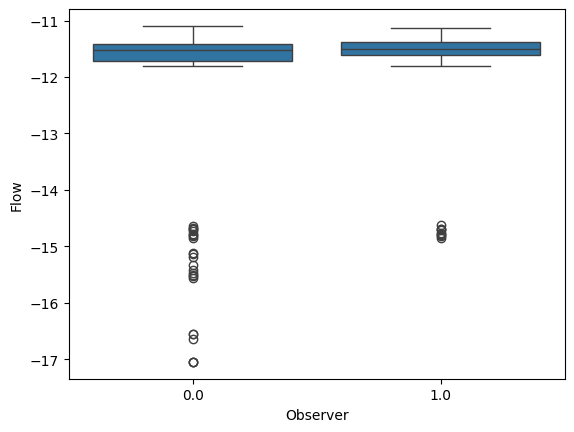

In [21]:
# higher values were recorded by observer 1
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=data, x="Observer", y="Flow")
plt.show()

Here we can also tell that the fewer (as stated above) measurements recorded by observer 1 also tend to be of a higher value with far less spread among outliers.  

I also want to highlight a few other arguments for observer bias. The p-value of the observer is 5.71e-161 (on par with the geometric variable). This suggest that the observer has an effect on the predicted flow. This is the main reason as to how we can statistically show that the null hypothesis for the observer variable is rejected. On the other hand the Pearson r-value is never above 0.23 indicating low correlation. This could indicate that the observer might not have a meaningful impact on the measurements in the data set.  

## Summary  

Spoiler alert: the data set has been collected by the teacher in this course. And as has been mentioned during lectures the reason that the relationship between the features is so strong is due to them being fundamental in fluid dynamics.  

That is why our model can show such high values in R² and the relevance between sets be so static. However it has still been a challenge to correctly performing a "statistical analysis", meaning implementing tools to measure and evaluate the model.  

I have also enjoyed the opportunity to try my hands on a predictive model and look forward to learning more about machine learning techniques.  